# [Self-Driving Car] Advanced Lane Finding
---
The purpose of this pipeline is to analyse the frames in a video of a driving car and identify the lanes ahead, as well as its curvature. Computational complexity is reduced by using data from the previous frame to predict the position of the lane in the next frame.

Each frame of the input video is to look like the image below, at the end of the pipeline.

<img src="intermediate_steps/complete.jpg" alt="Final Product" width="500px">

# Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# Calibrate the Camera
Utilise the calibration images to find the parameters that will correct for radial and tangential distortion

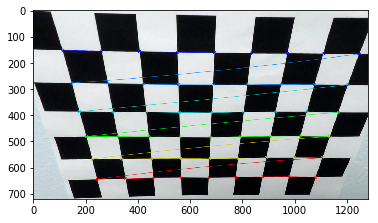

In [25]:
def get_calibrate_parameters(n, m):
    objpoint = []
    imgpoint = []
    
    # Load in each image in the calibration folder
    for file in glob.glob("calibration_images/calibration*.jpg"):
        img = cv2.imread(file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Locate the positions of the chess-board corners
        ret, corners = cv2.findChessboardCorners(gray, (n,m), None)
        if not ret: continue
        imgpoint.append(corners)
        
        # Prepare corresponding img points
        objp = np.zeros((m*n,3), np.float32)
        objp[:,:2] = np.mgrid[0:n,0:m].T.reshape(-1,2)
        objpoint.append(objp)
    
    # Return the calibration parameters
    ret2, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoint, imgpoint, gray.shape[::-1], None, None)   
    
    # print an example calibrated image
    img = cv2.drawChessboardCorners(img, (n,m), corners, ret)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.imshow(dst)
    return mtx, dist

# Find the camera's calibration parameters
mtx, dist = get_calibrate_parameters(9,6)

# Read in an image
This image will be used to test the pipeline before it runs on the video footage

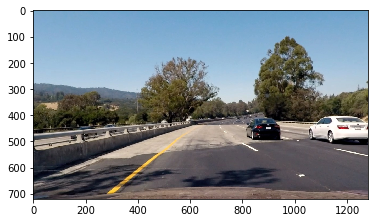

In [3]:
#reading in an image
image = plt.imread('input_test_images/test4.jpg')
image = cv2.undistort(image, mtx, dist, None, mtx)

#printing out the image
void = plt.imshow(image)

---
# Thresholding
In the next section, various method will be employed to detect the lanes in the images

## Gradient Threshold Functions
The following functions use the sobel operator to detect the gradient and direction of intensity changes in the image

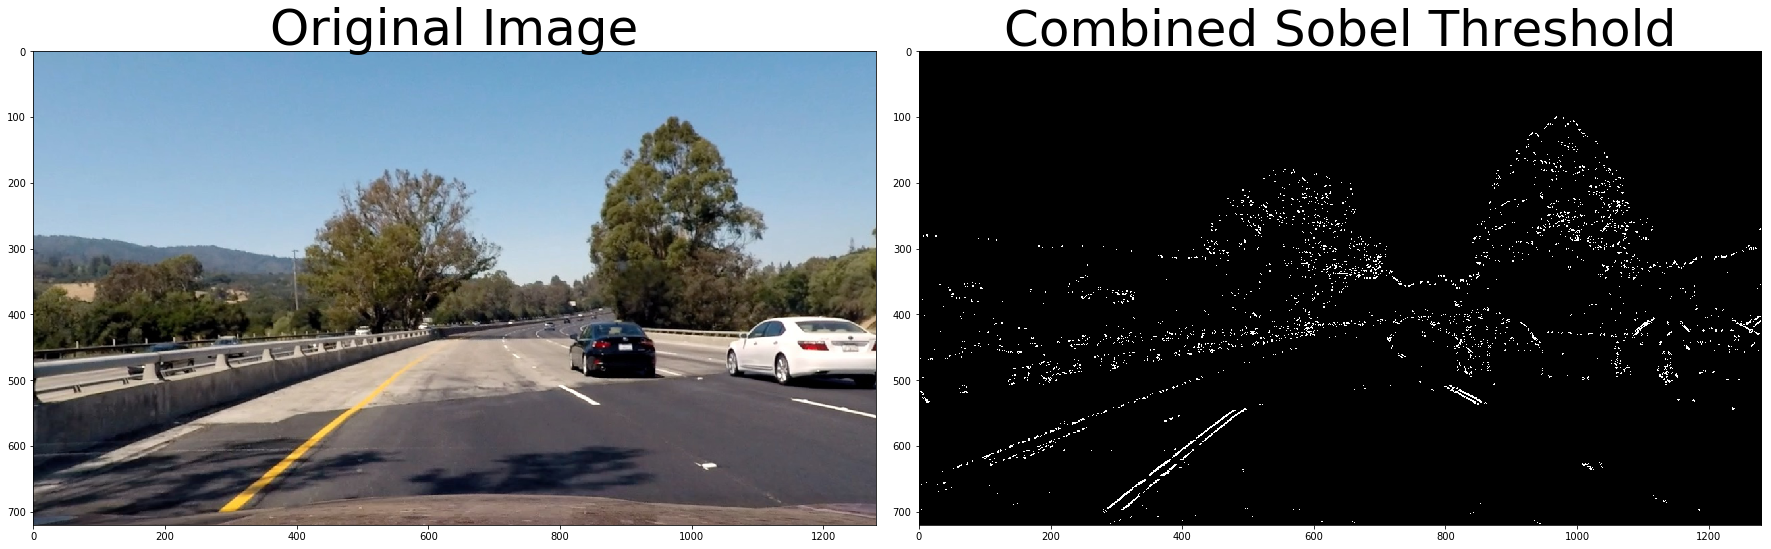

In [4]:
# Determine the directional gradient in either the 'x' or the 'y' direction
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find the raw gradient values
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # Find the absolute value and scale
    abs_sobel = np.absolute(sobel)
    scale_sobel = np.uint8((abs_sobel/np.max(abs_sobel))*255)
    
    # Translate the detected pixels into a binary
    grad_binary = np.zeros_like(gray)
    grad_binary[(scale_sobel >= thresh[0]) & (scale_sobel <= thresh[1])] = 1
    
    return grad_binary

# Determine the magnitude of the overall gradient at each location
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find the combined magnitude of the gradient
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    mag = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale and translate the results into a binary
    scale_mag = np.uint8(255*mag/np.max(mag))
    binary_output = np.zeros_like(scale_mag)
    binary_output[(scale_mag >= thresh[0]) & (scale_mag <= thresh[1])] = 1
    
    return binary_output

# Determine the direction of each gradient
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction and make a binary
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# An appropriate mix of thresholds is combined and returned. 
def combine_sobel_thresh(img, mag_kern=3, dir_kern=3, xthresh=(0,255), ythresh=(0,255), magthresh=(0,255), dirthresh=(0, np.pi/2)):
    
    # Get a binary for each threshold function
    gradx = abs_sobel_thresh(img, 'x', mag_kern, xthresh)
    grady = abs_sobel_thresh(img, 'y', mag_kern, ythresh)
    mag_binary = mag_thresh(img, mag_kern, magthresh)
    dir_binary = dir_threshold(img, dir_kern, dirthresh)
    
    # Combine the thresholds into one binary
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

# Hyper parameters, tuned by using the below image
x_sobel_thresh = (40,100)
y_sobel_thresh = (40,100)
mag_sobel_thresh = (40,200)
dir_sobel_thresh = (0.7, 1.2)
mag_kern = 3
dir_kern = 5

# Plot the result
binary = combine_sobel_thresh(image, mag_kern, dir_kern, x_sobel_thresh, y_sobel_thresh, mag_sobel_thresh, dir_sobel_thresh)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Combined Sobel Threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color Threshold Functions
The following function uses the HLS colour encoding method to determine the lane

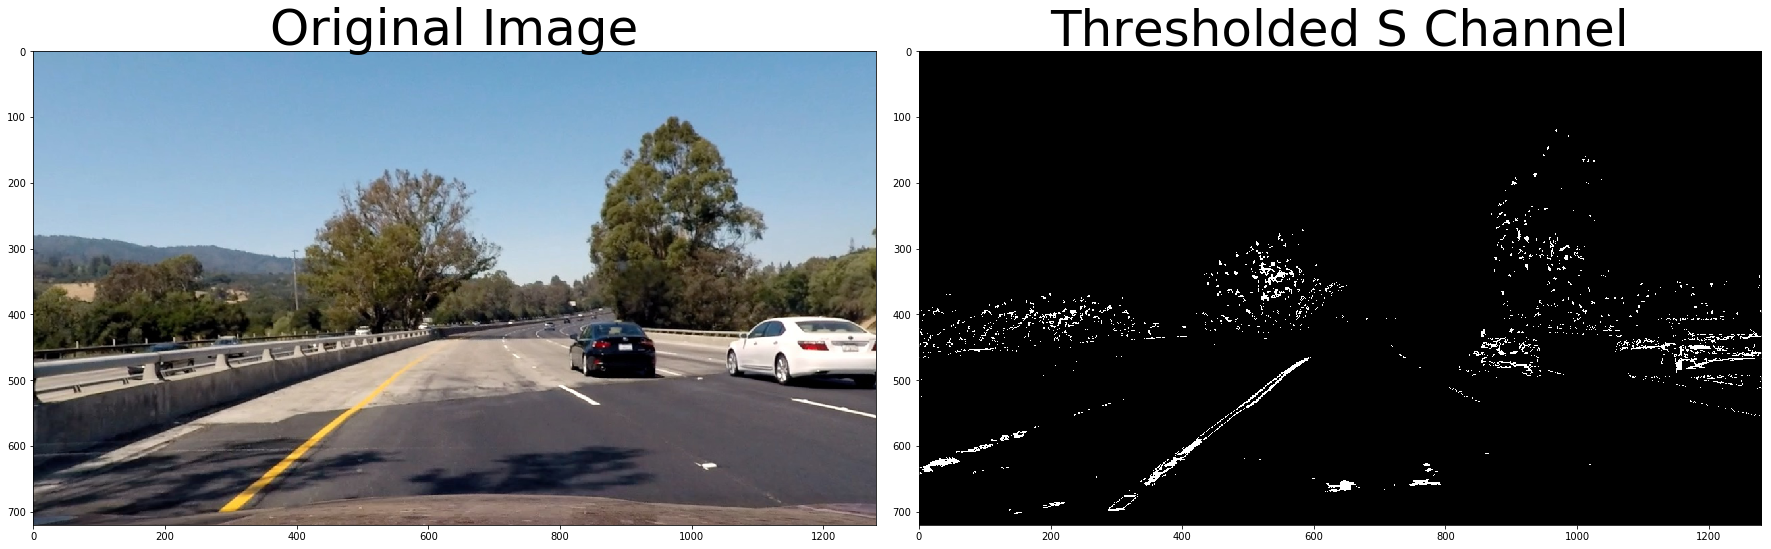

In [5]:
# Find the lane using the 's' channel of the HLS encoding method
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Isolate the 's' channel
    s = hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s <= thresh[1]) & (s > thresh[0])] = 1
    return binary_output

# Hyperparameters selected by tuning the image below
s_thresh = (150, 235)

# Plot the result
hls_binary = hls_select(image, s_thresh)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S Channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combining All Thresholds
The following function combines the threshold binaries into one stack

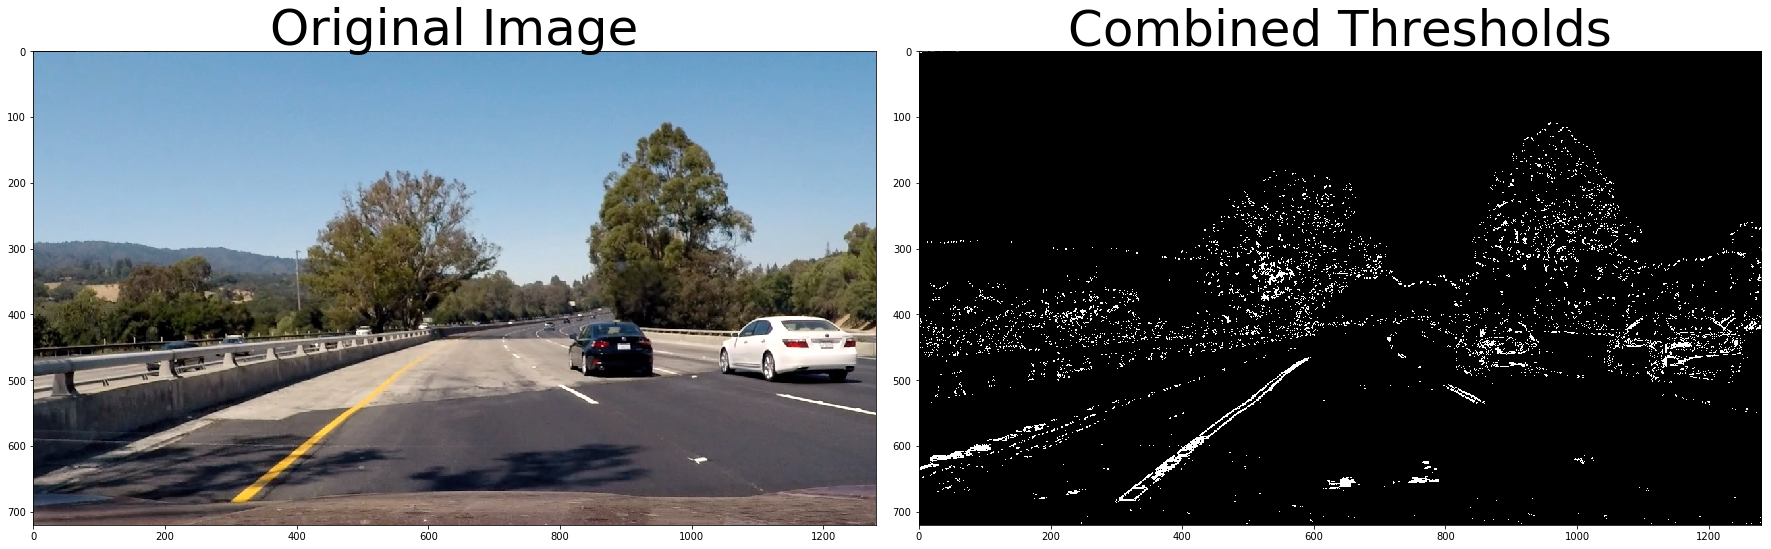

In [24]:
# Calls the previous thresholding functions, and combines them into one binary
def find_lane(img):
    sobel_binary = combine_sobel_thresh(img, mag_kern, dir_kern, x_sobel_thresh, y_sobel_thresh, mag_sobel_thresh, dir_sobel_thresh)
    hls_binary = hls_select(img, s_thresh)
    binary = np.zeros_like(hls_binary)
    binary[(hls_binary == 1) | (sobel_binary == 1)] = 1
    return binary

# Example calling this function on the test photo
binary = find_lane(image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Combined Thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
# Perspective Transform
In order to fit the lanes with an appropriate curve, and to calculate the car's position, a perspective transform must be made. This will enable the lanes to look as if they were viewed from above.

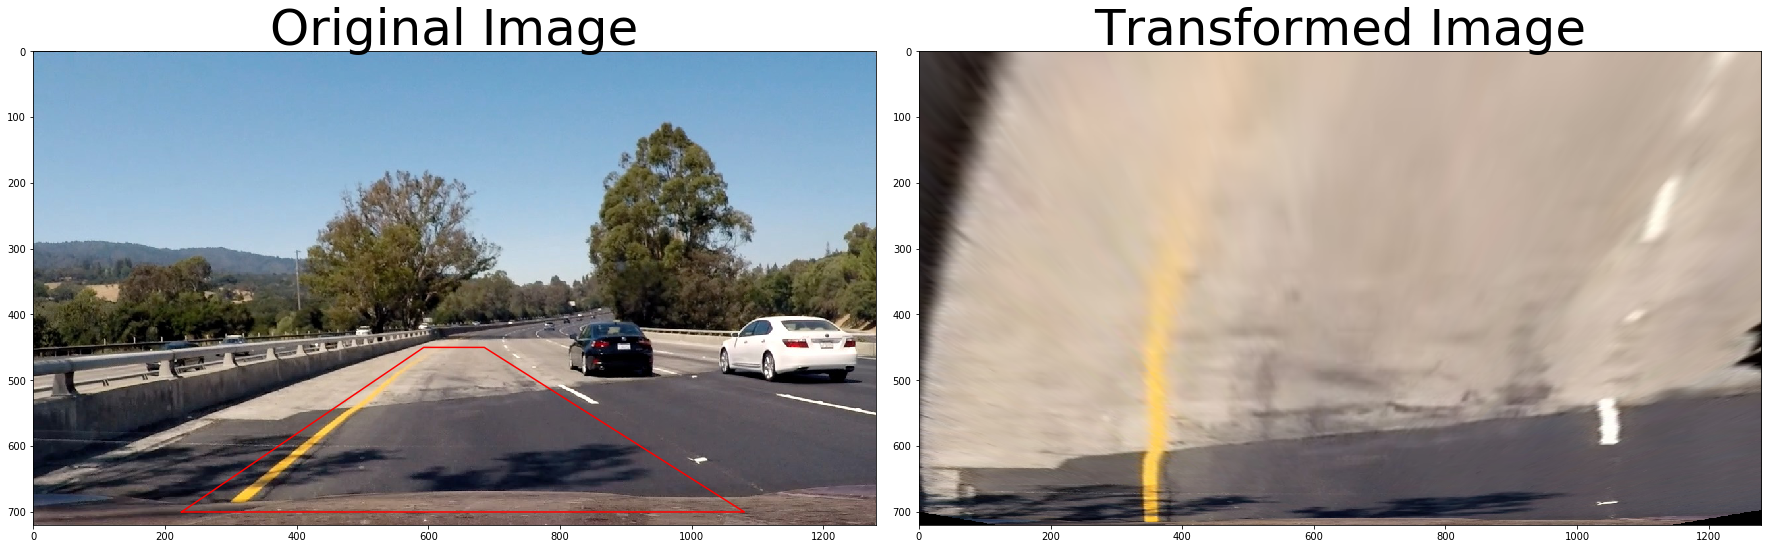

In [22]:
# Transform the image into a birdseye view
def transform_perspective(img):
    y = img.shape[0]
    x = img.shape[1]
    src = np.float32([[225,700],[1080,700],[594,450], [685,450]])
    dst = np.float32([[300,y], [x-300, y], [300, 0], [x-300, 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    Warped = cv2.warpPerspective(img, M, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return Warped, Minv

# Example calling this function on the test photo
warped, minv = transform_perspective(image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.plot([225, 1080, 685, 593, 225], [700, 700, 450, 450, 700], '-r')
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
# Model The Lanes
The next set of functions aim to detect and model the lane lines with a mathematical function. This will enable the car's radius of curvature to be determined. 

## Finding the Lanes: Recording Previous Frames
This section defines the class that will store information from the previous frame. This can then be used to determine the position of the lanes in the next frame.

In [8]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        
        # x values of the last n fits of the left and right line
        self.recent_xLeftfitted = []
        self.recent_xRightfitted = []
        
        # Average polynomial coefficients over the last n iterations
        self.best_fitLeft = []
        self.best_fitRight = []  
        
        #polynomial coefficients for the most recent fit
        self.current_fit_left = [np.array([False])]
        self.current_fit_right = [np.array([False])]
        
        #radius of curvature of the line in m
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 


## Finding the Lanes: Histogram Peaks
Now for the actual code. The following section will plot the transformed image onto a histogram, to determine the approximate locations of the lanes in the frame.

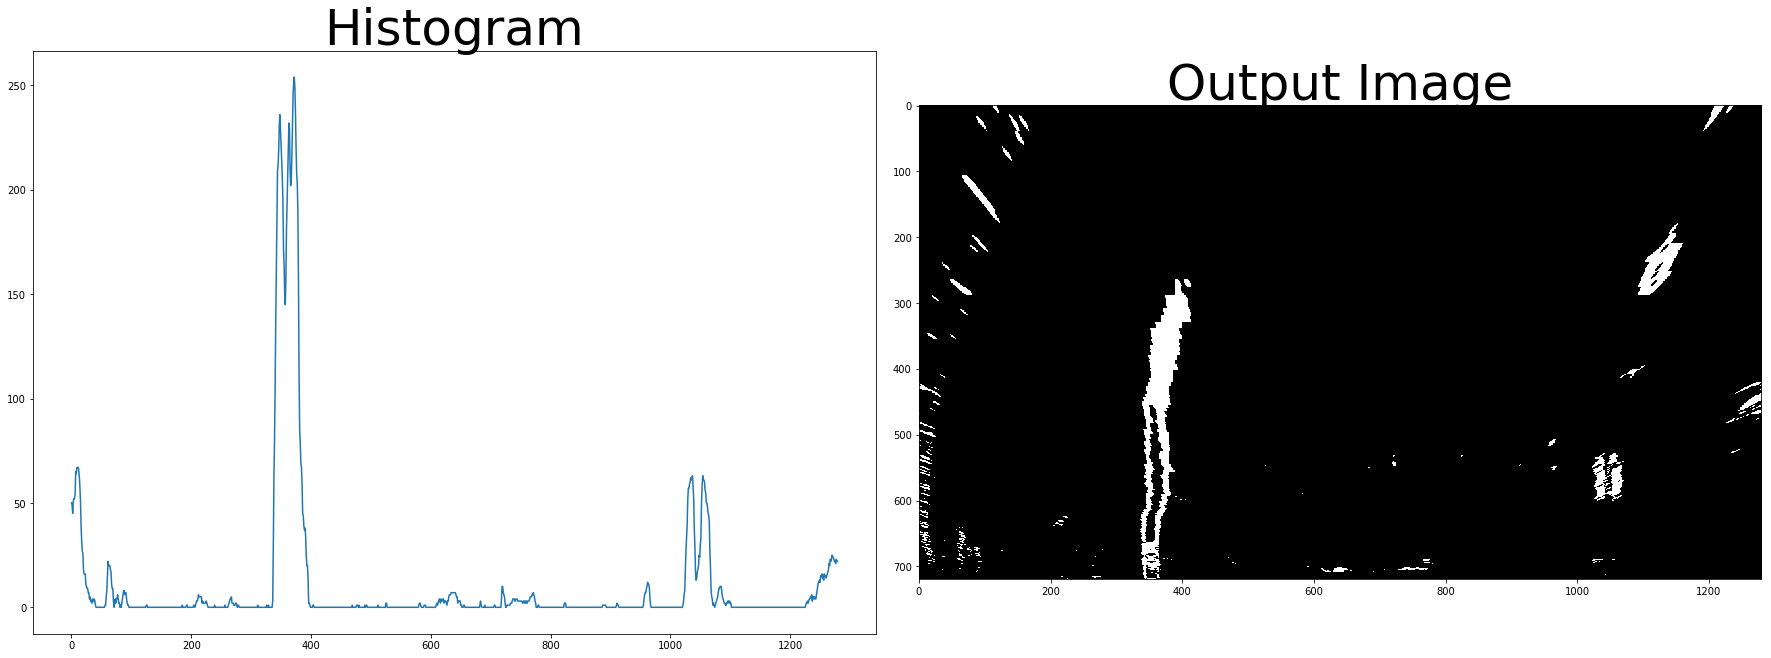

In [20]:
# This function takes a warped/transformed binary and finds the lane positions
def hist_detect(binary_warped):
    
    # Creates a histogram from the bottom half of the image
    bottom_half = binary_warped[binary_warped.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    
    # Finds the peak: where the most activated pixels are located in the image
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return histogram, leftx_base, rightx_base, out_img

# Example calling this function on the test photo
binary_warped, minv = transform_perspective(binary)
histogram, leftx_base, rightx_base, out_img = hist_detect(binary_warped)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.plot(histogram)
ax1.set_title('Histogram', fontsize=50)
ax2.imshow(out_img)
ax2.set_title('Output Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Finding the Lanes: Following the Curve
The next set of functions will use the sliding window method to "follow" the pixels as they curve around the image with the lane

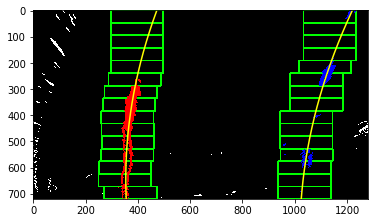

In [19]:
# This function sets windows onto the image based on NO prior information
def fit_new_windows(binary_warped, plot):
    
    # Find the histogram
    histogram, leftx_base, rightx_base, out_img = hist_detect(binary_warped)
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        if plot == 1:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 5) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 5)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If more than minpix pixels were found, recenter the next window
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

# This function plots the polynomial that follows the data
def fit_new_polynomial(binary_warped, plot):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = fit_new_windows(binary_warped, plot)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        ret_val = 1
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        ret_val = 0

    if plot == 1:
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    return ret_val, left_fit, right_fit, out_img, left_fitx, right_fitx

# Hyperparameters found by tuning the image below
nwindows = 15
margin = 100
minpix = 70

# Example image is plotted below
ret, left_fit, right_fit, out_img, void, void = fit_new_polynomial(binary_warped,1)
void = plt.imshow(out_img)

## Finding the Lanes: Using Previous Frames
The following section includes the functions required to use previous frame data to optimise the process for looking for the lane again

In [11]:
def fit_polynomial(img_shape, leftx, lefty, rightx, righty):
    
    # As before, fit a simple 2nd order curve to each lane
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, left_fit, right_fit, ploty

def search_around_poly(binary_warped, prev_leftfit, prev_rightfit):
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Search for pixels within an area around the previous fit
    left_lane_inds = ((nonzerox > (prev_leftfit[0]*(nonzeroy**2) + prev_leftfit[1]*nonzeroy + 
                    prev_leftfit[2] - margin)) & (nonzerox < (prev_leftfit[0]*(nonzeroy**2) + 
                    prev_leftfit[1]*nonzeroy + prev_leftfit[2] + margin)))
    right_lane_inds = ((nonzerox > (prev_rightfit[0]*(nonzeroy**2) + prev_rightfit[1]*nonzeroy + 
                    prev_rightfit[2] - margin)) & (nonzerox < (prev_rightfit[0]*(nonzeroy**2) + 
                    prev_rightfit[1]*nonzeroy + prev_rightfit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, left_fit, right_fit, ploty = fit_polynomial(binary_warped.shape, leftx, lefty, rightx, righty)
    return left_fitx, right_fitx, left_fit, right_fit, out_img

## Finding the Lanes: Curvature & Position Calculation
The following section includes the functions required to calculate the curvature of the lane modelled by the fits above. It also includes the function to calculate the car's position with respect to the lane lines.

In [12]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def measure_curvature_real(ploty, left_fit, right_fit):
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def measure_car_offset(ploty, left_fit, right_fit, midpoint):
    y = np.max(ploty)
    
    # Find the distance of the lanes from the centre of the car
    dL = midpoint - (left_fit[0]*y**2 + left_fit[1]*y + left_fit[2])
    dR = midpoint - (right_fit[0]*y**2 + right_fit[1]*y + right_fit[2])
    dL = np.absolute(dL)
    dR = np.absolute(dR)
    
    # Find the offset
    offset = np.absolute(dL-dR)/2
    offset = offset * xm_per_pix
    return offset

---
# Pipeline
The section below is the complete code that must be run for each frame of the video. It runs using a combination of all the functions defined above. It assumes that the camera's calibration values, and the hypervalues set above, are already in the global address space.

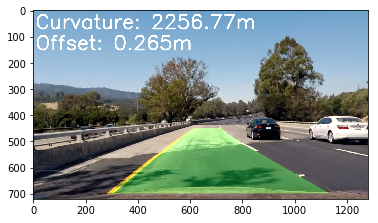

In [18]:
# HYPERPARAMETERS
n_smooth = 3

def find_lane_pipeline(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Obtain the binary that combines all of the thresholds
    binary = find_lane(img)
    
    # Perspective transform the binary
    binary_warped, Minv = transform_perspective(binary)
    
    
    
    # If the last image has no image detected
    if line.detected == False:
        ret, left_fit, right_fit, out_img, Lfitx, Rfitx = fit_new_polynomial(binary_warped,0)
        line.detected = True
    else:
        Lfitx, Rfitx, left_fit, right_fit, out_img = search_around_poly(binary_warped, line.best_fitLeft[-1], line.best_fitRight[-1])
        
        
    # UPDATING LEFT TREND
    # remove the last element on the list if it is beyond n_smooth
    if len(line.recent_xLeftfitted) == n_smooth+1: 
        voidL = line.recent_xLeftfitted.pop(0)
        voidL = line.best_fitLeft.pop(0)
    
    # add the new fitted x data
    line.recent_xLeftfitted.append(Lfitx)
    
    # Find the mean of the existing trend lines and new trend, and append it
    if len(line.best_fitLeft) != 0:
        line.best_fitLeft.append(left_fit)
        new_fitL = np.mean(line.best_fitLeft, axis=0)
        line.best_fitLeft.pop()
        line.best_fitLeft.append(new_fitL)
    else:
        line.best_fitLeft.append(left_fit)
        
    # UPDATING RIGHT TREND
    # remove the last element on the list if it is beyond n_smooth
    if len(line.recent_xRightfitted) == n_smooth+1: 
        voidL = line.recent_xRightfitted.pop(0)
        voidL = line.best_fitRight.pop(0)
    
    # add the new fitted x data
    line.recent_xRightfitted.append(Rfitx)

    # Find the mean of the existing trend lines and new trend, and append it
    if len(line.best_fitRight) != 0:
        line.best_fitRight.append(right_fit)
        new_fitR = np.mean(line.best_fitRight, axis=0)
        line.best_fitRight.pop()
        line.best_fitRight.append(new_fitR)
    else:
        line.best_fitRight.append(right_fit)
    
    # Update current fit
    line.current_fit_left = line.best_fitLeft[-1]
    line.current_fit_right = line.best_fitRight[-1]
    
    # Create an image to draw the lane on
    warped, Minv = transform_perspective(img)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    
    # Recast the x and y points into usable formats
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])      
    pts_left = np.transpose(np.vstack([line.recent_xLeftfitted[-1], ploty]))
    pts_right = np.flipud(np.transpose(np.vstack([line.recent_xRightfitted[-1], ploty])))
    pts = np.vstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_(np.array([pts])), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_zero, Minv, (warped.shape[1], warped.shape[0]))
    
    # Combine the result with the original image
    final_img = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    # Calculate lane curvature  
    L_curve, R_curve = measure_curvature_real(ploty, line.current_fit_left, line.current_fit_right)
    curvature = (L_curve + R_curve)/2
    
    # Add offset and curvature text
    curve = "Curvature: {:.2f}m".format(curvature)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(final_img, curve, (10,70), font, 2.5, (255, 255, 255), 5, cv2.LINE_AA)
    
    # Calculate offset
    midpoint = np.int(binary_warped.shape[1]//2)
    offset = measure_car_offset(ploty, line.current_fit_left, line.current_fit_right, midpoint)
    
    # Add offset and curvature text
    off = "Offset: {:.3f}m".format(offset)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(final_img, off, (10,150), font, 2.5, (255, 255, 255), 5, cv2.LINE_AA)
    
    return final_img

# Run a test image on the pipeline
image = plt.imread('input_test_images/test4.jpg')
line = Line()
final_img = find_lane_pipeline(image)
void = plt.imshow(final_img)

---
# Running the Pipeline on a Video
The next section will run the pipeline on a series of videos.

In [14]:
white_output = 'video_output/project_video.mp4'
clip1 = VideoFileClip("input_video/project_video.mp4")
line = Line()
white_clip = clip1.fl_image(find_lane_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video video_output/project_video.mp4.
Moviepy - Writing video video_output/project_video.mp4



Moviepy - Done !
Moviepy - video ready video_output/project_video.mp4
Wall time: 5min 6s


---
# Final Result

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="video_output/project_video.mp4">
</video>
""")